# Neural Style Transfer

This work based on Alexis Jacq <https://pytorch.org/tutorials/advanced/neural_style_tutorial.html>

In [1]:
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

## Download images

In [4]:
!wget -O something.jpg https://render.fineartamerica.com/images/rendered/search/print/8/8/break/images/artworkimages/medium/2/1-curvilinear-bright-i-lanie-loreth.jpg

--2021-01-02 02:59:59--  https://render.fineartamerica.com/images/rendered/search/print/8/8/break/images/artworkimages/medium/2/1-curvilinear-bright-i-lanie-loreth.jpg
Resolving render.fineartamerica.com (render.fineartamerica.com)... 52.85.144.64, 52.85.144.73, 52.85.144.34, ...
Connecting to render.fineartamerica.com (render.fineartamerica.com)|52.85.144.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30843 (30K) [image/jpeg]
Saving to: ‘something.jpg’

something.jpg       100%[===================>]  30.12K  --.-KB/s    in 0s      

2021-01-02 02:59:59 (368 MB/s) - ‘something.jpg’ saved [30843/30843]



## Preprocessing


In [5]:
IMSIZE = 512  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
loader = transforms.Compose([
    transforms.Resize(IMSIZE),  # Load and divide by 255
    transforms.CenterCrop(IMSIZE), # Take a crop in center
    transforms.ToTensor()])  # to PyTorch Tensor object

In [7]:
def image_loader(image_name):
    image = Image.open(image_name) # Open PIL image
    image = loader(image).unsqueeze(0) # Load and add new dim
    return image.to(DEVICE, torch.float) # to DEVICE

In [8]:
style_img_1 = image_loader("something.jpg")  # First style image 
style_img_2 = image_loader("style1.jpg")  # Second style image
content_img = image_loader("me.jpg")  # Content image

In [9]:
def make_mask(img_shape, num_channels):
    """
    Function create a binary mask with given shape of tensors 
    (1, num_channels, img_shape, img_shape)
    All positions below digonal elements are ones, the rest are zeros
    ---
    img_shape - W or H of tensor
    num_channels - number of filters in convolution layer
    ---
    mask - Tensor (1, num_channels, img_shape, img_shape)
    """
    mask = torch.zeros((img_shape, img_shape))  

    for i in range(img_shape):  # Fill mask with ones
      for j in range(img_shape):
        mask[i,j] = 1 if i>j else 0

    mask = mask.unsqueeze(0)  # add new dim

    # sample mask to number of filters
    mask = mask.expand(num_channels,img_shape,img_shape)  
    mask = mask.unsqueeze(0) # add new dim (create batch)
    return mask

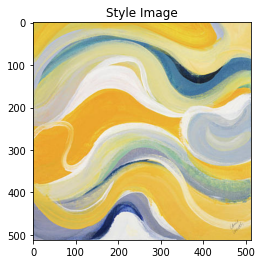

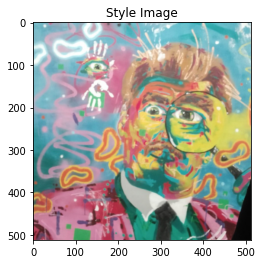

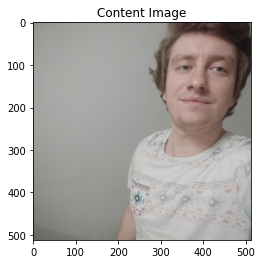

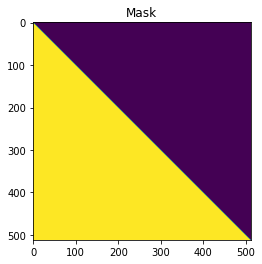

In [10]:
unloader = transforms.ToPILImage() # Transformation of tensor to picture

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

plt.figure()
imshow(style_img_1, title='Style Image 1')

plt.figure()
imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(make_mask(IMSIZE, 1)[0], title = 'Mask')

## Model

### Content Loss
------


In [11]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach() 
            self.loss = F.mse_loss(self.target, self.target)
            
        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

### Style loss
------
Style loss can be applied to content image by using two different style images each through own mask

In [12]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()
       
        features = input.view(batch_size * h, w * f_map_num) 

        G = torch.mm(features, features.t()) 
        
        return G.div(batch_size * h * w * f_map_num)

In [13]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2, mode=2):
            super(StyleLoss, self).__init__()
            self.mode = mode
            self.target1 = gram_matrix(target_feature1).detach()
            self.target2 = gram_matrix(target_feature2).detach()
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something
            self.init_masks = True
            self.mask = None
            self.inv_mask= None

        def forward(self, input):
            # Mode for 2 style images
            if self.mode == 2:
                if self.init_masks: # To initialize mask once with correct dims
                    _, channels, img_shape, _ = input.shape
                    # Normal mask
                    self.mask = make_mask(img_shape, channels).to(DEVICE).detach()
                    # Reversed mask, top side has ones, bottom has zeros
                    self.inv_mask = torch.where(self.mask != 0,
                                                torch.zeros_like(self.mask),
                                                torch.ones_like(self.mask)).detach()
                    self.init_masks = False  # Turn off future initialization

                G1 = gram_matrix(input*self.mask)
                G2 = gram_matrix(input*self.inv_mask)

                # Here can be weights for each part of mask but currently
                # it works well with 1:1 
                self.loss = F.mse_loss(G1, self.target1) + F.mse_loss(G2, self.target2)
            else:
                G1 = gram_matrix(input)
                self.loss = F.mse_loss(G1, self.target1)
            return input

### Normalization layer
---

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)

In [15]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

### Model modification
---

In [16]:
cnn = models.vgg19(pretrained=True).features.to(DEVICE).eval()

In [17]:
# Define layers after which losses will be applied
content_layers_default = ['conv_5', 'conv_6']
style_layers_default = ['conv_1','conv_2', 'conv_5','conv_6']

In [18]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img_1, style_img_2,content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(DEVICE)

        # just in order to have an iterable access to or list of content/style
        # losses
        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_img_1).detach()
                target_feature2 = model(style_img_2).detach()
                # mode = 1 for 1 style image
                # mode = 2 for 2 style images
                style_loss = StyleLoss(target_feature1, target_feature2, mode=2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

## Training

In [19]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [20]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img_1, style_img_2, input_img, num_steps=1000,
                        style_weight=1e10, content_weight=1): #100000
        """Run the style transfer."""
        print('Building the style transfer model..')

        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img_1, style_img_2, content_img)
        optimizer = get_input_optimizer(input_img)


        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score 
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    plt.figure()
                    input_img.data.clamp_(0, 1)
                    imshow(input_img, title='Output Image')
                    plt.ioff()
                    plt.show()
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

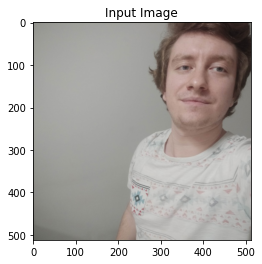

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 85454.734375 Content Loss: 117382.296875


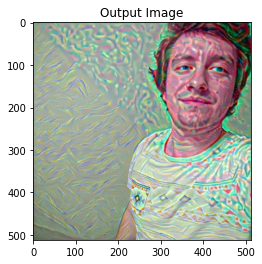


run [100]:
Style Loss : 46092.750000 Content Loss: 108868.125000


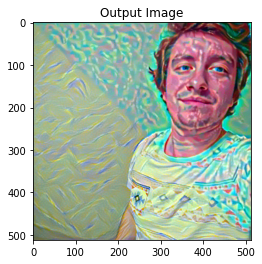


run [150]:
Style Loss : 35300.523438 Content Loss: 106036.820312


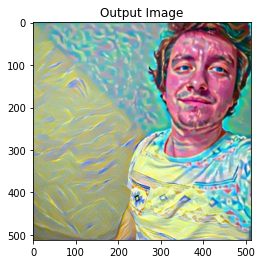


run [200]:
Style Loss : 24810.462891 Content Loss: 105814.242188


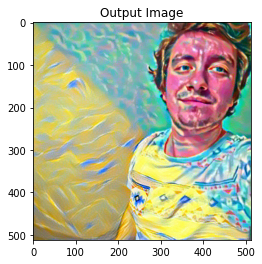


run [250]:
Style Loss : 19632.904297 Content Loss: 104067.031250


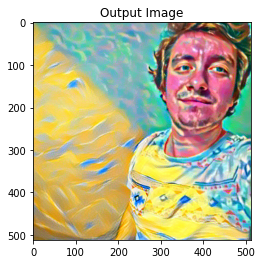


run [300]:
Style Loss : 18656.591797 Content Loss: 102252.625000


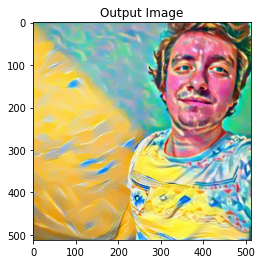


run [350]:
Style Loss : 17614.820312 Content Loss: 101553.789062


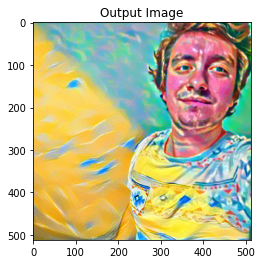


run [400]:
Style Loss : 17315.646484 Content Loss: 101268.054688


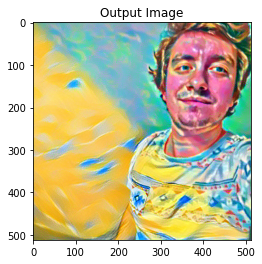


run [450]:
Style Loss : 17246.835938 Content Loss: 100385.562500


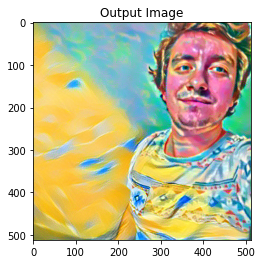


run [500]:
Style Loss : 16807.941406 Content Loss: 100577.007812


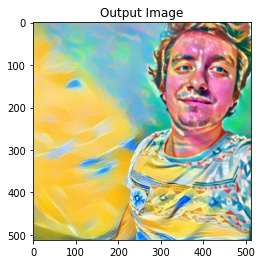


run [550]:
Style Loss : 16710.478516 Content Loss: 101162.765625


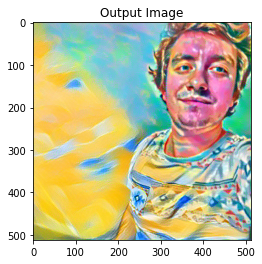


run [600]:
Style Loss : 21537.181641 Content Loss: 108004.968750


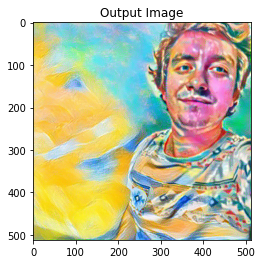

In [21]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn=cnn,
                            normalization_mean=cnn_normalization_mean,
                            normalization_std=cnn_normalization_std,
                            content_img = content_img,
                            style_img_1 = style_img_1,
                            style_img_2 = style_img_2,
                            input_img=input_img,
                            num_steps=600,
                            style_weight=1e8,
                            content_weight=1000)

## Resulted image
---

Resulted image


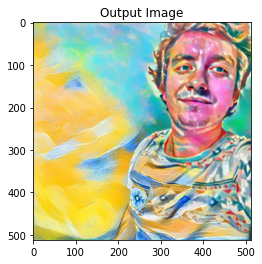

In [23]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()